In [2]:
import numpy as np
import torch
import torchvision
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import json

In [3]:
print(torch.__version__)

1.0.0


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
device

device(type='cuda')

In [6]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 32, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(64)
        
    
    def forward(self, x):
        x1 = F.leaky_relu(self.conv1(x), 0.2)
        x2 = F.leaky_relu(self.bn1(self.conv2(x1)), 0.2)
        x3 = F.leaky_relu(self.bn2(self.conv3(x2)), 0.2)
        x4 = F.leaky_relu(self.bn3(self.conv4(x3)), 0.2)
        x5 = F.leaky_relu(self.bn4(self.conv5(x4)), 0.2)
        x6 = F.leaky_relu(self.bn5(self.conv6(x5)), 0.2)
        return (x1, x2, x3, x4, x5, x6)
    
    def init(self, mean, std):
        for param in self.parameters():
            torch.nn.init.normal_(param, mean, std)

In [7]:
class Decoder(nn.Module):
    
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(96, 32, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(64, 3, 4, 2, 1)
    
    def forward(self, x):
        x1, x2, x3, x4, x5, x6 = x
        x5d = F.relu(F.dropout(self.bn1(self.conv1(x6))))
        x5 = torch.cat([x5d, x5], dim = 1)
        x4d = F.relu(F.dropout(self.bn2(self.conv2(x5))))
        x4 = torch.cat([x4d, x4], dim = 1)
        x3d = F.relu(F.dropout(self.bn3(self.conv3(x4))))
        x3 = torch.cat([x3d, x3], dim = 1)
        x2d = F.relu(F.dropout(self.bn4(self.conv4(x3))))
        x2 = torch.cat([x2d, x2], dim = 1)
        x1d = F.relu(F.dropout(self.bn5(self.conv5(x2))))
        x1 = torch.cat([x1d, x1], dim = 1)
        x = torch.tanh(self.conv6(x1))
        return x
    
    def init(self, mean, std):
        for param in self.parameters():
            torch.nn.init.normal_(param, mean, std)

In [8]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()
        self.enc.init(0, 0.02)
        self.dec.init(0, 0.02)
        
    def forward(self, x):
        h = self.enc(x)
        yh = self.dec(h)
        return yh
        

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 1, 4, 1, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn1(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))
        return x
    
    def init(self, mean, std):
        for param in self.parameters():
            torch.nn.init.normal_(param, mean, std)

In [10]:
train_img_dir = 'D:/viton_resize/train/image/'
test_img_dir = 'D:/viton_resize/test/image/'

train_img_map_dir = 'D:/viton_resize/train/image-parse/'
test_img_map_dir = 'D:/viton_resize/test/image-parse/'

train_pose_dir = 'D:/viton_resize/train/pose/'
test_pose_dir = 'D:/viton_resize/test/pose/'

train_cloth_dir = 'D:/viton_resize/train/cloth/'
test_cloth_dir = 'D:/viton_resize/test/cloth/'

train_cloth_mask_dir = 'D:/viton_resize/train/cloth-mask/'
test_cloth_mask_dir = 'D:/viton_resize/test/cloth-mask/'

In [11]:
path = os.path.join(train_pose_dir, '000004_0_keypoints.json')
with open(path) as fp:
    pose = json.load(fp)
pose = pose['people'][0]['pose_keypoints']
pose_coords = [(pose[i + 1], pose[i]) for i in range(0, len(pose), 3)]

In [12]:
pose_coords

[(38.1672727272727, 94.488188976378),
 (84.2472727272727, 91.7165354330709),
 (88.9018181818182, 53.1653543307087),
 (154.996363636364, 45.8582677165354),
 (223.185454545455, 39.8110236220472),
 (82.6181818181818, 130.51968503937),
 (158.021818181818, 140.346456692913),
 (220.858181818182, 138.07874015748),
 (209.221818181818, 65.259842519685),
 (0, 0),
 (0, 0),
 (208.058181818182, 116.409448818898),
 (0, 0),
 (0, 0),
 (31.4181818181818, 82.8976377952756),
 (28.6254545454545, 101.03937007874),
 (38.4, 68.5354330708661),
 (29.3236363636364, 110.110236220472)]

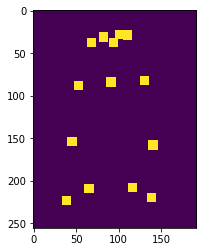

In [13]:
def get_pose_map(pose_coords):
    h = 256
    w = 192
    pose_map = np.zeros((h, w))
    for x, y in pose_coords:
        x = int(x)
        y = int(y)
        if x==0 and y==0:
            continue
        x_min = max(0, x - 5)
        x_max = min(h - 1, x + 5)
        y_min = max(0, y - 5)
        y_max = min(w - 1, y + 5)
        for i in range(x_min, x_max + 1):
            for j in range(y_min, y_max + 1):
                pose_map[i][j] = 1

    return pose_map

pose_map = get_pose_map(pose_coords)
plt.imshow(pose_map)

(256, 192, 18)


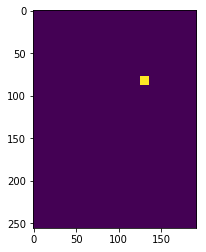

In [14]:
def get_pose_one_hot(pose_coords):
    h = 256
    w = 192
    pose_map = np.zeros((h, w, 18))
    for ch, (x, y) in enumerate(pose_coords):
        x = int(x)
        y = int(y)
        if x==0 and y==0:
            continue
        x_min = max(0, x - 5)
        x_max = min(h - 1, x + 5)
        y_min = max(0, y - 5)
        y_max = min(w - 1, y + 5)
        for i in range(x_min, x_max + 1):
            for j in range(y_min, y_max + 1):
                pose_map[i][j][ch] = 1

    return pose_map

pose_one_hot = get_pose_one_hot(pose_coords)
print(pose_one_hot.shape)
plt.imshow(pose_one_hot[:, :, 5].squeeze())

In [ ]:
def get_head_RGB(img_map, img):
    """
    Input: an RBG 8-bit image and its corresponding RGB segmentation mask 
    Output: RGB 8-bit image of just the head
    """
    head = np.zeros_like(img_map)
    mask = img_map == [0, 0, 255]
    head[mask] = img
    head[img_map == [255, 0, 0]] = 1
    
    

In [15]:
class VITONDataset(torch.utils.data.Dataset):
    
    def __init__(self, x_dir, y_dir, transform = None):
        self.x_dir = x_dir
        self.y_dir = y_dir
        self.transform = transform
        self.x_ids = os.listdir(self.x_dir) 
        self.y_ids = os.listdir(self.y_dir)
            
    def __len__(self):
        return len(self.x_ids)
    
    def __getitem__(self, idx):
        x_id = self.x_ids[idx]
        y_id = self.y_ids[idx]
        data = plt.imread(os.path.join(self.x_dir, x_id))
        label = plt.imread(os.path.join(self.y_dir, y_id))
        if self.transform:
            data = self.transform(data)
            label = self.transform(label)
        return data, label

In [16]:
m = 0.5
s = 0.5
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean = (m, m, m), std = (s, s, s))])

In [18]:
train_dataset = VITONDataset(train_img_map_dir, train_img_dir, transform)

In [19]:
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_workers=0,
                                     pin_memory=False)

In [26]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([1, 3, 256, 192]) torch.Size([1, 3, 256, 192])


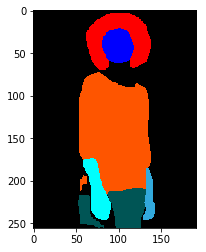

In [27]:
x = x.detach().cpu().numpy()
x = np.transpose(x, (2, 3, 1, 0))
x = np.squeeze(x)
x = x*s + m
plt.imshow(x)

In [28]:
x[40, 100]

array([0.        , 0.        , 0.99607843], dtype=float32)

In [29]:
x[20, 100]

array([0.99607843, 0.        , 0.        ], dtype=float32)

In [30]:
x[120, 100]

array([0.99607843, 0.33333334, 0.        ], dtype=float32)

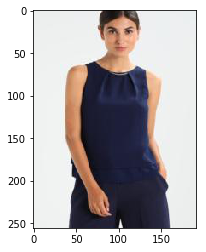

In [77]:
y = y.detach().cpu().numpy()
y = np.transpose(y, (2, 3, 1, 0))
y = np.squeeze(y)
plt.imshow(y*s + m)

In [47]:
mask = x[:]
mask[np.nonzero(x[:, :, 0] > 0.9)[0]

array([  4,   4,   4, ..., 214, 215, 215], dtype=int64)

In [78]:
G = Generator()
G.to(device)

Generator(
  (enc): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dec): Decoder(
    (conv1): ConvTran

In [79]:
D = Discriminator()
D.init(0, 0.02)
D.to(device)

Discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

In [137]:
Es = Encoder()
Es.init(0, 0.02)
Es.to(device)

Encoder(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [138]:
Ds = Decoder()
Ds.init(0, 0.02)
Ds.to(device)

Decoder(
  (conv1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(96, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [80]:
D_optimizer = optim.Adam(D.parameters(), lr = 0.0002, betas=(0.5, 0.999)) 
G_optimizer = optim.Adam(G.parameters(), lr = 0.0002, betas=(0.5, 0.999)) 

In [97]:
BCE = nn.BCELoss()
L1 = nn.L1Loss()
train_loss = []
n_epochs = 1

for e in range(n_epochs):
    for i in range(len(train_loader)):
        data, label = next(iter(train_loader))
        data = data.to(device)
        label = label.to(device)
            
        Gx = G(data)
        fake_data = torch.cat([Gx, data], dim = 1)
        real_data = torch.cat([label, data], dim = 1)

        y_fake = D(fake_data)
        y_real = D(real_data)

        D_loss = 0.5*(BCE(y_real, torch.ones_like(y_real).to(device)) + \
                      BCE(y_fake, torch.zeros_like(y_fake).to(device)))

        D_optimizer.zero_grad()
        D_loss.backward() 
        D_optimizer.step()
        
        Gx = G(data)
        fake_data = torch.cat([Gx, data], dim = 1)
        y_fake = D(fake_data)

        G_loss = (BCE(y_fake, torch.ones_like(y_fake).to(device)) + 20*L1(Gx, label))

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        train_loss.append((G_loss.item(), D_loss.item()))
        
        if i % 500 == 0:
            print('epoch = {}, iter = {}, loss = {:.4f}, {:.4f}'.format(e, i, train_loss[-1][0],
                                                                   train_loss[-1][1]))        

epoch = 0, iter = 0, loss = 7.4412, 0.3560
epoch = 0, iter = 500, loss = 7.2690, 0.4239
epoch = 0, iter = 1000, loss = 6.9743, 0.5043
epoch = 0, iter = 1500, loss = 6.6870, 0.7503


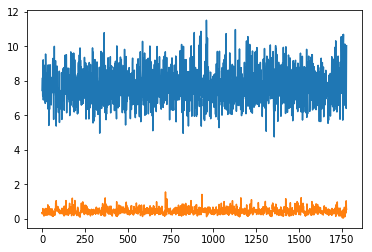

In [98]:
plt.plot(train_loss)

In [99]:
val_dataset = VITONDataset(test_x_dir, test_y_dir, transform)

In [100]:
batch_size = 5
val_loader = torch.utils.data.DataLoader(val_dataset,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_workers=0,
                                     pin_memory=False)

In [104]:
data, label = next(iter(val_loader))
data = data.to(device)
label = label.to(device)

In [105]:
Gx = G(data)
Gx = Gx.detach().cpu().numpy()
Gx = np.transpose(Gx, (2, 3, 1, 0))
Gx = Gx*s*np.ones_like(Gx)
Gx = Gx + m*np.ones_like(Gx)

label = label.detach().cpu().numpy()
label = np.transpose(label, (2, 3, 1, 0))
label = label*s*np.ones_like(label)
label = label + m*np.ones_like(label)

data = data.detach().cpu().numpy()
data = np.transpose(data, (2, 3, 1, 0))
data = data*s*np.ones_like(data)
data = data + m*np.ones_like(data)

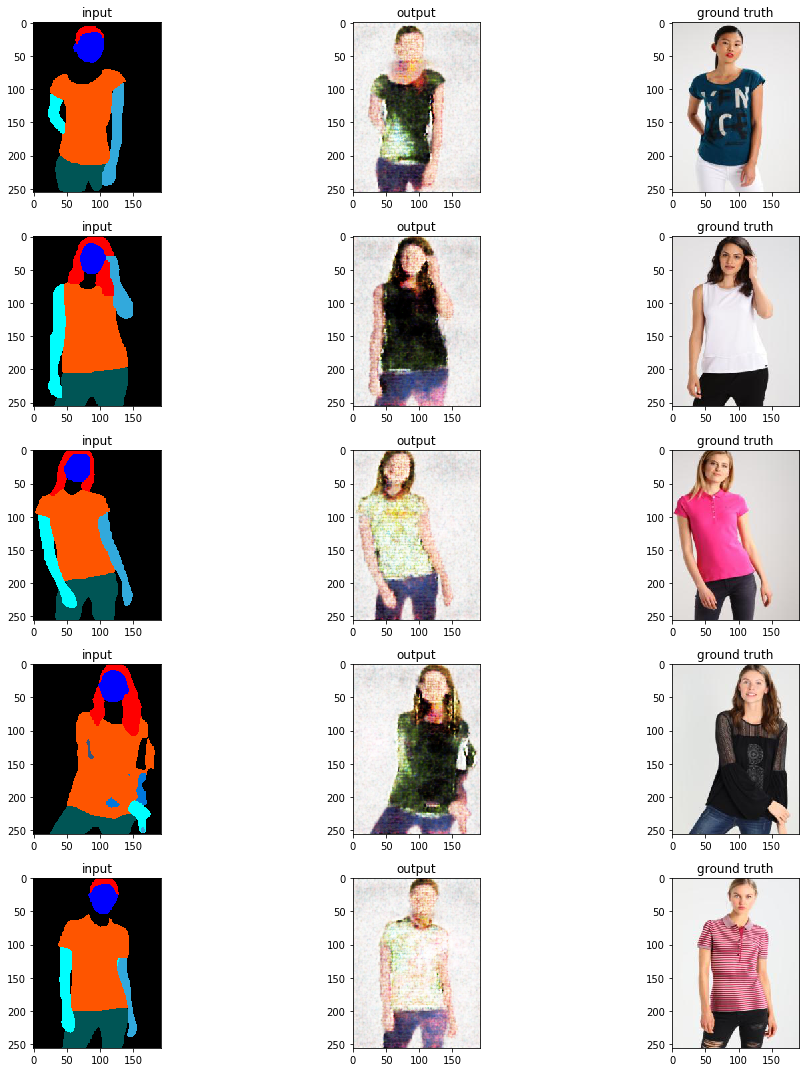

In [106]:
fig = plt.figure(figsize = (15, 15))
c = 3
for i in range(batch_size):
    fig.add_subplot(batch_size, c, i*c + 1)
    plt.imshow(data[:, :, :, i])
    plt.title('input')
    fig.add_subplot(batch_size, c, i*c + 2)
    plt.imshow(Gx[:, :, :, i])
    plt.title('output')
    fig.add_subplot(batch_size, c, i*c + 3)
    plt.imshow(label[:, :, :, i])
    plt.title('ground truth')
fig.tight_layout()